In [1]:
import timeit
import statistics
import sys
import os
from matplotlib import pyplot as plt

sys.path.append('..')

from ruv.relative_utility_value import *
from ruv.damage_functions import *
from ruv.economic_models import *
from ruv.utility_functions import *
from ruv.helpers import *
from ruv.decision_methods import *

In [2]:
def load_data(awrc, start_lt, end_lt, area, scenario='muthre', input_path='../../muthre_results/muthre_csv'):
    print('Loading data')
    results = load_from_csv(awrc, start_lt, end_lt, scenario, input_path)
    results = mm_to_m3s(results, area)
    return results['obs'], results['fcst'], results['clim']


# fetch data from MUTHRE CSV file for single AWRC, scenario, and range of lead-times
# Replace missing forecast values with mean of each ensemble for each timestep (notify user)
# Create a non-ragged climatology with missing values removed
def load_from_csv(awrc, start_lt, end_lt, scenario='muthre', input_path='muthre_csv'):
    print('\tLoading data for %s/%s from lead-time %d to %d' % (awrc, scenario, start_lt, end_lt))

    obs_fcst_df = pd.read_csv(os.path.join(input_path, awrc, '%s-%s.csv.gz' % (awrc, scenario)), index_col=0, parse_dates=True, compression='gzip')
    clim_df = pd.read_csv(os.path.join(input_path, awrc, '%s-%s.csv.gz' % (awrc, 'climatology')), index_col=0, parse_dates=True, compression='gzip')

    obs, fcst_ens, clim = get_data(obs_fcst_df, clim_df, start_lt, end_lt)
    print('\tobs shape: %s, fcst_ens shape: %s, clim shape: %s' % (obs.shape, fcst_ens.shape, clim.shape))

    return {
        'obs': obs,
        'clim': clim,
        'fcst': fcst_ens
    }


# Parse dataframes from MUTHRE CSV file for lead-time
# TODO: sort out all these unnessary transposes
def get_data(obs_fcst_df, clim_df, start_leadtime, end_leadtime):
    obs_fcst_df = get_leadtime(obs_fcst_df, start_leadtime, end_leadtime)
    obs = get_obs(obs_fcst_df).values
    fcst_ens = get_ensemble(obs_fcst_df).T.values

    # replace any missing fcst ens values with the mean of each ensemble for each timestep
    tmp = fcst_ens.T
    count = 0
    for i in range(tmp.shape[0]):
        j = np.where(np.isnan(tmp[i]))
        tmp[i][j] = np.nanmean(tmp[i])
        count += len(j[0])
    fcst_ens = tmp.T

    if count > 0:
        print('\t%d missing values out of %d detected in forecast ensemble, replaced with ensemble mean for each timestep' % (count, fcst_ens.size))

    # create non-ragged climatology with missing values removed
    clim = clean_clim(get_ensemble(get_leadtime(clim_df, start_leadtime, end_leadtime))).T if clim_df is not None else None

    return obs, fcst_ens.T, clim.T


def get_obs(df):
    return df.obs


# return all the xth lead-time
def get_leadtime(df, lt_day_of_mth_start, lt_day_of_mth_end):
    if lt_day_of_mth_start == 'all':
        return df

    lt_day_of_mth_start = int(lt_day_of_mth_start)
    lt_day_of_mth_end = int(lt_day_of_mth_end)

    idx = df.index
    lt_val = []
    for lt in range(lt_day_of_mth_start, lt_day_of_mth_end+1):
        lt_idx = idx.groupby(idx.day)[lt]
        lt_val.append(df.loc[lt_idx])

    lt_val = pd.concat(lt_val)
    lt_val.sort_index(inplace=True)

    return lt_val


def get_ensemble(df):
    ens_cols = list(df.columns)
    ens_cols.remove('obs')
    ens_cols.remove('date')
    return df[ens_cols]


# return a non-ragged climatology with missing values removed
def clean_clim(df):
    max_size_ens = (df.shape[1] - df.T.isna().sum()).min()  # eg. 496 non-NA members for LT 7 of Biggara
    ens = np.full((len(df), max_size_ens), np.nan)
    for i,irow in enumerate(df.iterrows()):
        row = irow[1]
        ens[i] = row.dropna()[0:max_size_ens] #.sample(max_size_ens)
    return ens


def mm_to_m3s(results, area):
    factor = area * 1000 / (60 * 60 * 24)
    results['obs'] = results['obs'] * factor
    results['fcst'] = results['fcst'] * factor
    results['clim'] = results['clim'] * factor
    return results

In [3]:
awrc = '405209'
name = 'Acheron River at Tagerty'
area = 629.4

start_lt=1
end_lt=30

target_unity_risk_aversion = 0.3
max_damages = 10000
damages_quantile_threshold = 0.99
damages_shape = 0.2

num_alphas = 10
benchmark_repeats = 20
num_timesteps = 50

benchmark_name = '5'

In [4]:
verbose = False
alphas = np.linspace(1/num_alphas, 1-1/num_alphas, num_alphas)
target_risk_premium = risk_aversion_coef_to_risk_premium(target_unity_risk_aversion, 1)
adjusted_risk_aversion = risk_premium_to_risk_aversion_coef(target_risk_premium, max_damages)

C:\Users\me\work\research\software\relative-utility-value\ruv\helpers.py:64: RuntimeWarning: overflow encountered in exp
  return np.log(0.5 * (np.exp(-A * gamble_size) + np.exp(A * gamble_size))) / (A * gamble_size) - risk_premium


In [5]:
obs, fcst, clim = load_data(awrc, start_lt, end_lt, area)
ref = clim
obs = obs[0:num_timesteps]
fcst = fcst[0:num_timesteps]
ref = ref[0:num_timesteps]

Loading data
	Loading data for 405209/muthre from lead-time 1 to 30
	obs shape: (8240,), fcst_ens shape: (8240, 100), clim shape: (8240, 508)


In [6]:
decision_definition = {
    'damage_function': [logistic, {'A': max_damages, 'k': damages_shape, 'threshold': np.nanquantile(obs, damages_quantile_threshold)}],
    'utility_function': [cara, {'A': adjusted_risk_aversion}],
    'economic_model': [cost_loss, cost_loss_analytical_spend, alphas],
    'decision_thresholds': np.arange(0, 20, 2),
    'decision_making_method': [optimise_over_forecast_distribution, None],
}

In [7]:
results = {}
print('Starting benchmark')

for cores in range(1, 9):
    benchmark_results = timeit.repeat(
        lambda: relative_utility_value(obs, fcst, ref, decision_definition, parallel_nodes=cores), number=1, repeat=benchmark_repeats)

    times = np.array(benchmark_results) / num_alphas / num_timesteps * 1000

    print('\n%d timesteps with cores=%d' % (num_timesteps, cores))
    print('Mean time per alpha per timestep: %.4f +/- %.4f ms' % (statistics.mean(times), statistics.stdev(times)))
    
    if cores > 1:
        print('Speedup factor: %.4f (vs %d)' % (statistics.mean(results[1]) / statistics.mean(times), cores))

    results[cores] = times

Starting benchmark

50 timesteps with cores=1
Mean time per alpha per timestep: 1.6034 +/- 0.2433 ms

50 timesteps with cores=2
Mean time per alpha per timestep: 1.2913 +/- 0.3710 ms
Speedup factor: 1.2417 (vs 2)

50 timesteps with cores=3
Mean time per alpha per timestep: 1.3724 +/- 0.6513 ms
Speedup factor: 1.1683 (vs 3)

50 timesteps with cores=4
Mean time per alpha per timestep: 1.2693 +/- 0.5300 ms
Speedup factor: 1.2632 (vs 4)

50 timesteps with cores=5
Mean time per alpha per timestep: 1.4330 +/- 0.6137 ms
Speedup factor: 1.1189 (vs 5)

50 timesteps with cores=6
Mean time per alpha per timestep: 1.7278 +/- 0.9280 ms
Speedup factor: 0.9280 (vs 6)

50 timesteps with cores=7
Mean time per alpha per timestep: 1.9337 +/- 1.3036 ms
Speedup factor: 0.8292 (vs 7)

50 timesteps with cores=8
Mean time per alpha per timestep: 1.9339 +/- 2.1588 ms
Speedup factor: 0.8291 (vs 8)


In [8]:
msec_per_alpha_timestep = pd.DataFrame(results)
msec_per_alpha_timestep.to_csv('benchmark_results_%s.csv' % benchmark_name)

In [9]:
mean_msec_per_alpha_timestep = msec_per_alpha_timestep.mean(axis=0)
speedups = mean_msec_per_alpha_timestep.iloc[0] / mean_msec_per_alpha_timestep

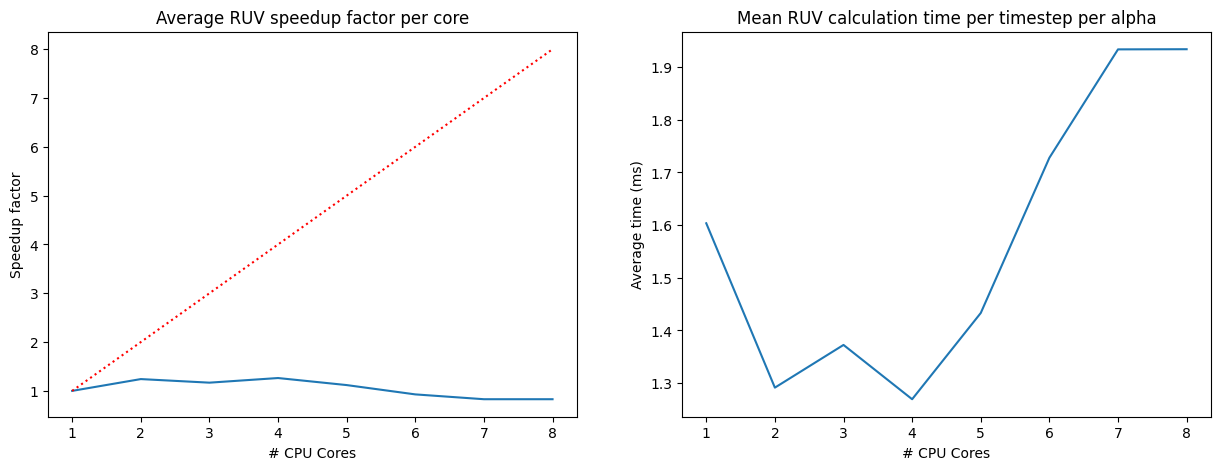

In [10]:
plt.subplots(1, 2, figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
speedups.plot(ax=ax1, xlabel='# CPU Cores', ylabel='Speedup factor', title='Average RUV speedup factor per core')
ax1.plot(range(1, 9), range(1, 9), linestyle=':', color='red')
ax2 = plt.subplot(1, 2, 2)
mean_msec_per_alpha_timestep.plot(ax=ax2, xlabel='# CPU Cores', ylabel='Average time (ms)', title='Mean RUV calculation time per timestep per alpha')
plt.savefig('benchmark_results_%s.png' % benchmark_name)